# Customer segmentaion using K-means clustering

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Reading Dataset

In [2]:
df = pd.read_csv('data/Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [6]:
df.rename(columns= { 'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'spending_score'}, inplace=True)

In [7]:
df.head()

,CustomerID,Gender,Age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Exploratory Data Analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


* Looks like annual income has right skewed distribution and has outliers

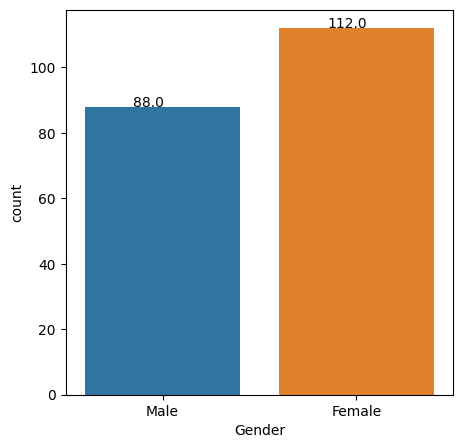

In [9]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x="Gender", data=df)
plt.xlabel('Gender')

for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

* Both gender have balanced contribution to the dataset

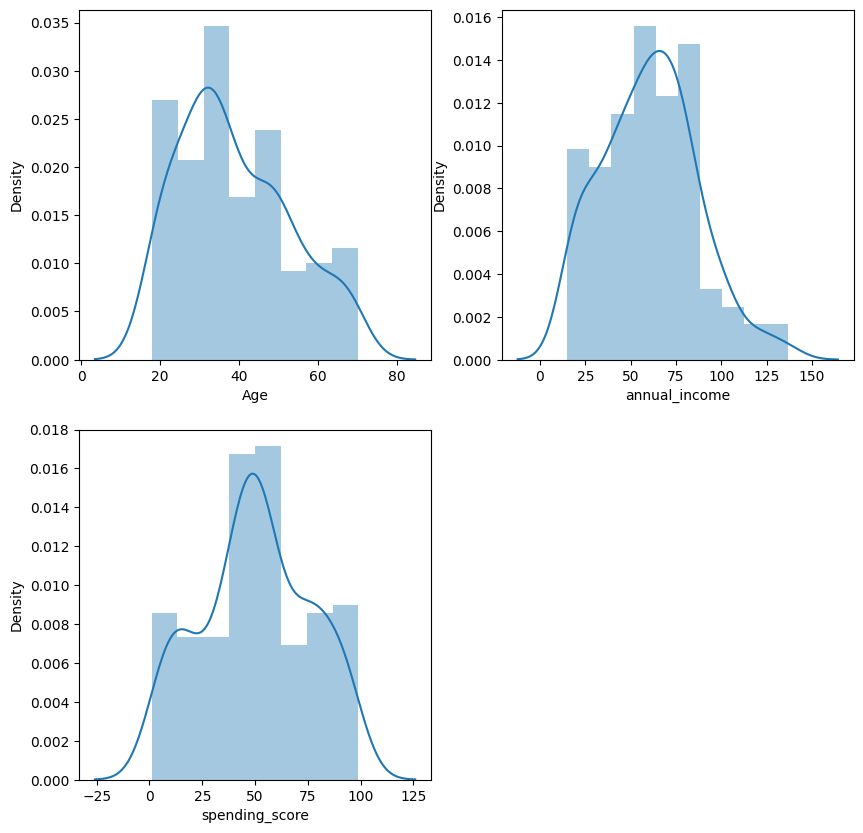

In [10]:
#distribution of numerical features
num_feat = ['Age', 'annual_income', 'spending_score']

plt.figure(figsize=(10,10))

for i, col in enumerate(num_feat, 1):
    plt.subplot(2,2,i)
    sns.distplot(df[col])

* Age and annual income has right skewed distribution
* More number of customers have spending score in range 40 - 60

### Data Preprocessing

In [11]:
#checking for null values
df.isnull().sum()

CustomerID        0
Gender            0
Age               0
annual_income     0
spending_score    0
dtype: int64

In [12]:
#checking for duplicated entries
df.duplicated().sum()

0

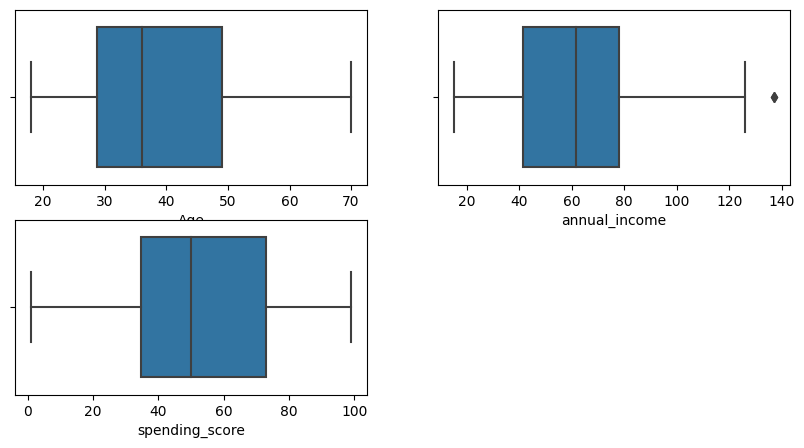

In [13]:
#checking for outliers
plt.figure(figsize=(10,5))

for i, col in enumerate(num_feat, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=df[col])

In [14]:
#handling outliers
q1 = df['annual_income'].quantile(0.25)
q3 = df['annual_income'].quantile(0.75)

iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

df = df[df['annual_income'] < upper_limit]

<AxesSubplot: xlabel='annual_income'>

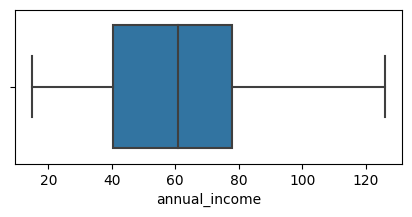

In [15]:
plt.figure(figsize=(5,2))
sns.boxplot(x= df['annual_income'])

In [16]:
#encoding gender column
df['Gender'] = [1 if x == 'Male' else 0 for x in df['Gender']]

In [17]:
df['Gender'].value_counts()

0    112
1     86
Name: Gender, dtype: int64

In [18]:
#dropping customerID column
df = df.drop('CustomerID', axis=1)

In [19]:
df.head()

,Gender,Age,annual_income,spending_score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [20]:
#creating feature matrix
X = df.values
X

array([[  1,  19,  15,  39],
       [  1,  21,  15,  81],
       [  0,  20,  16,   6],
       [  0,  23,  16,  77],
       [  0,  31,  17,  40],
       [  0,  22,  17,  76],
       [  0,  35,  18,   6],
       [  0,  23,  18,  94],
       [  1,  64,  19,   3],
       [  0,  30,  19,  72],
       [  1,  67,  19,  14],
       [  0,  35,  19,  99],
       [  0,  58,  20,  15],
       [  0,  24,  20,  77],
       [  1,  37,  20,  13],
       [  1,  22,  20,  79],
       [  0,  35,  21,  35],
       [  1,  20,  21,  66],
       [  1,  52,  23,  29],
       [  0,  35,  23,  98],
       [  1,  35,  24,  35],
       [  1,  25,  24,  73],
       [  0,  46,  25,   5],
       [  1,  31,  25,  73],
       [  0,  54,  28,  14],
       [  1,  29,  28,  82],
       [  0,  45,  28,  32],
       [  1,  35,  28,  61],
       [  0,  40,  29,  31],
       [  0,  23,  29,  87],
       [  1,  60,  30,   4],
       [  0,  21,  30,  73],
       [  1,  53,  33,   4],
       [  1,  18,  33,  92],
       [  0,  

In [21]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Model Training

#### Finding best value for K (number of clusters)

In [22]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state = 5)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

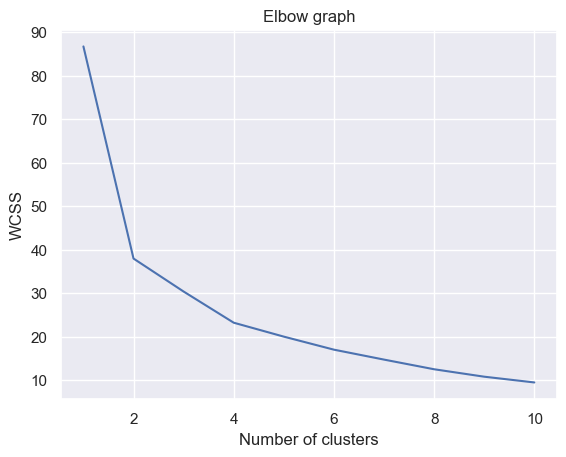

In [23]:
sns.set()
sns.lineplot(x=range(1,11), y=wcss)
plt.title('Elbow graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

* Best value for K is  4

### K-means with K = 4

In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=1)

y = kmeans.fit_predict(X)
y

array([1, 1, 2, 0, 0, 0, 2, 0, 3, 0, 3, 0, 2, 0, 3, 1, 2, 1, 3, 0, 3, 1,
       2, 1, 2, 1, 2, 1, 2, 0, 3, 0, 3, 1, 2, 0, 2, 0, 2, 0, 2, 1, 3, 0,
       2, 0, 2, 0, 0, 0, 2, 1, 0, 3, 2, 3, 2, 3, 0, 3, 3, 1, 2, 2, 3, 1,
       2, 2, 1, 0, 3, 2, 2, 2, 3, 1, 2, 3, 0, 2, 3, 1, 3, 2, 0, 3, 2, 0,
       0, 2, 2, 1, 3, 2, 0, 1, 2, 0, 3, 1, 0, 2, 3, 1, 3, 0, 2, 3, 3, 3,
       3, 0, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0, 3, 1, 3, 1, 3, 1,
       0, 0, 3, 0, 2, 1, 3, 0, 2, 1, 0, 0, 3, 1, 3, 0, 2, 1, 3, 1, 2, 0,
       2, 0, 3, 0, 3, 0, 2, 0, 3, 0, 3, 0, 3, 0, 2, 1, 3, 1, 3, 1, 2, 0,
       3, 1, 3, 1, 2, 0, 3, 0, 2, 1, 2, 1, 2, 0, 2, 0, 3, 0, 2, 0, 2, 1])

In [25]:
df['cluster'] = y
df.head()

,Gender,Age,annual_income,spending_score,cluster
0,1,19,15,39,1
1,1,21,15,81,1
2,0,20,16,6,2
3,0,23,16,77,0
4,0,31,17,40,0


In [26]:
df['cluster'].value_counts()

0    57
2    55
3    47
1    39
Name: cluster, dtype: int64

* 57 customers belongs to cluster 0
* 39 customers belongs to cluster 1
* 55 customers belongs to cluster 2
* 47 customers belongs to cluster 3

### Model evaluation

In [27]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print('Silhouette score - ', silhouette_score(X, y, metric='euclidean'))
print('Calinski-Harabasz index - ', calinski_harabasz_score(X, y))
print('Davies-Bouldin index - ', davies_bouldin_score(X, y))

Silhouette score -  0.3554256746559882
Calinski-Harabasz index -  176.79370627693356
Davies-Bouldin index -  1.1686846178978452


### Cluster Visulaization

#### Spending Score vs Age

<AxesSubplot: xlabel='spending_score', ylabel='Age'>

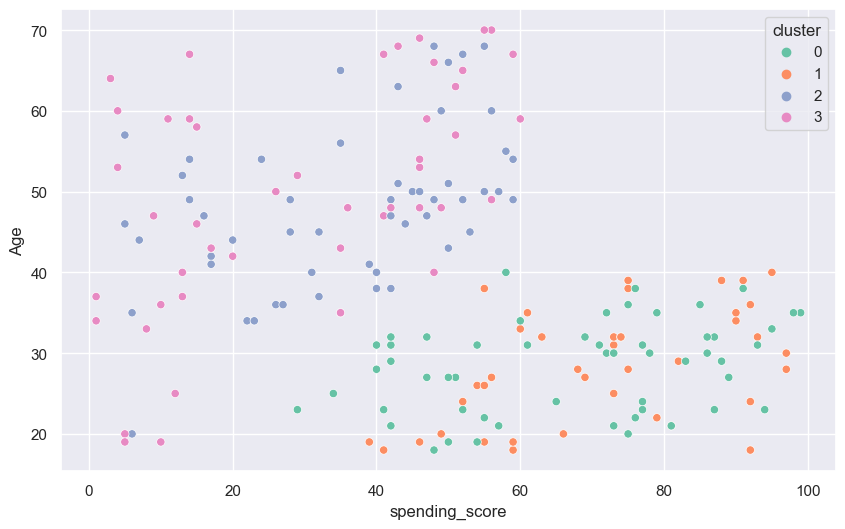

In [42]:
plt.figure(figsize=(10,6))

sns.scatterplot(x='spending_score', y='Age', data=df, hue='cluster', palette='Set2')

* Clustering is done 4 dimensional space because we had four features, so it is harder to distinguish clusters in 2d graph
* cluster 0 and cluster 1 includes custmers below age 40 and higher spending score
* cluster 3 and cluster 2 contians more elder customers and their spending_score is lower than other clusters